# A comparison of the static displacement of Mindlin-Reissner and Kirchhoff-Love plates using a semi-analytic Navier solution under the effect of a uniformly distributed constant load

# Navier's semi-analytic solution

In [10]:
import numpy as np
from numpy import ascontiguousarray as ascont

from sigmaepsilon.solid.material import (
    MindlinPlateSection,
    KirchhoffPlateSection,
    ElasticityTensor,
    LinearElasticMaterial
)
from sigmaepsilon.solid.fourier import (
    RectangularPlate,
    LoadGroup,
    RectangleLoad,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix


def calculate_UZ(size: tuple, shape: tuple, model: str) -> float:
    # geometry
    Lx, Ly, t = size

    # material
    E = 2890.0
    nu = 0.2

    # material stiffness matrix
    hooke = elastic_stiffness_matrix(E=E, NU=nu)
    stiffness = ElasticityTensor(hooke, tensorial=False)
    material = LinearElasticMaterial(stiffness=stiffness)
    section_type = MindlinPlateSection if model == "MR" else KirchhoffPlateSection
    section = section_type(
        layers=[
            section_type.Layer(material=material, thickness=t),
        ]
    )
    ABDS = section.elastic_stiffness_matrix()
    D, S = ascont(ABDS[:3, :3]), ascont(ABDS[3:, 3:])
    if not model == "MR":
        S = None

    # uniform distributed load
    loads = LoadGroup(
        LC1=RectangleLoad(x=[[0, 0], [Lx, Ly]], v=[-0.1, 0, 0]),
    )
    loads.lock()

    coords = np.array([[Lx, Ly, 0]], dtype=float)
    plate = RectangularPlate((Lx, Ly), shape, D=D, S=S)
    results = plate.solve(loads, coords)

    # return results["LC1"][0, 0].values  # this would return the same value
    return results["LC1"].sel(point=0, component = "UZ")

## Plotting

In [11]:
def generate_plot_data(size, thicknesses):
    Lx, Ly = size
    nx, ny = 20, 20
    absdiff = []
    for t in thicknesses:
        UZ_MR = calculate_UZ((Lx, Ly, t), (nx, ny), "MR")
        UZ_KL = calculate_UZ((Lx, Ly, t), (nx, ny), "KL")
        absdiff.append(UZ_MR / UZ_KL - 1)
    return absdiff

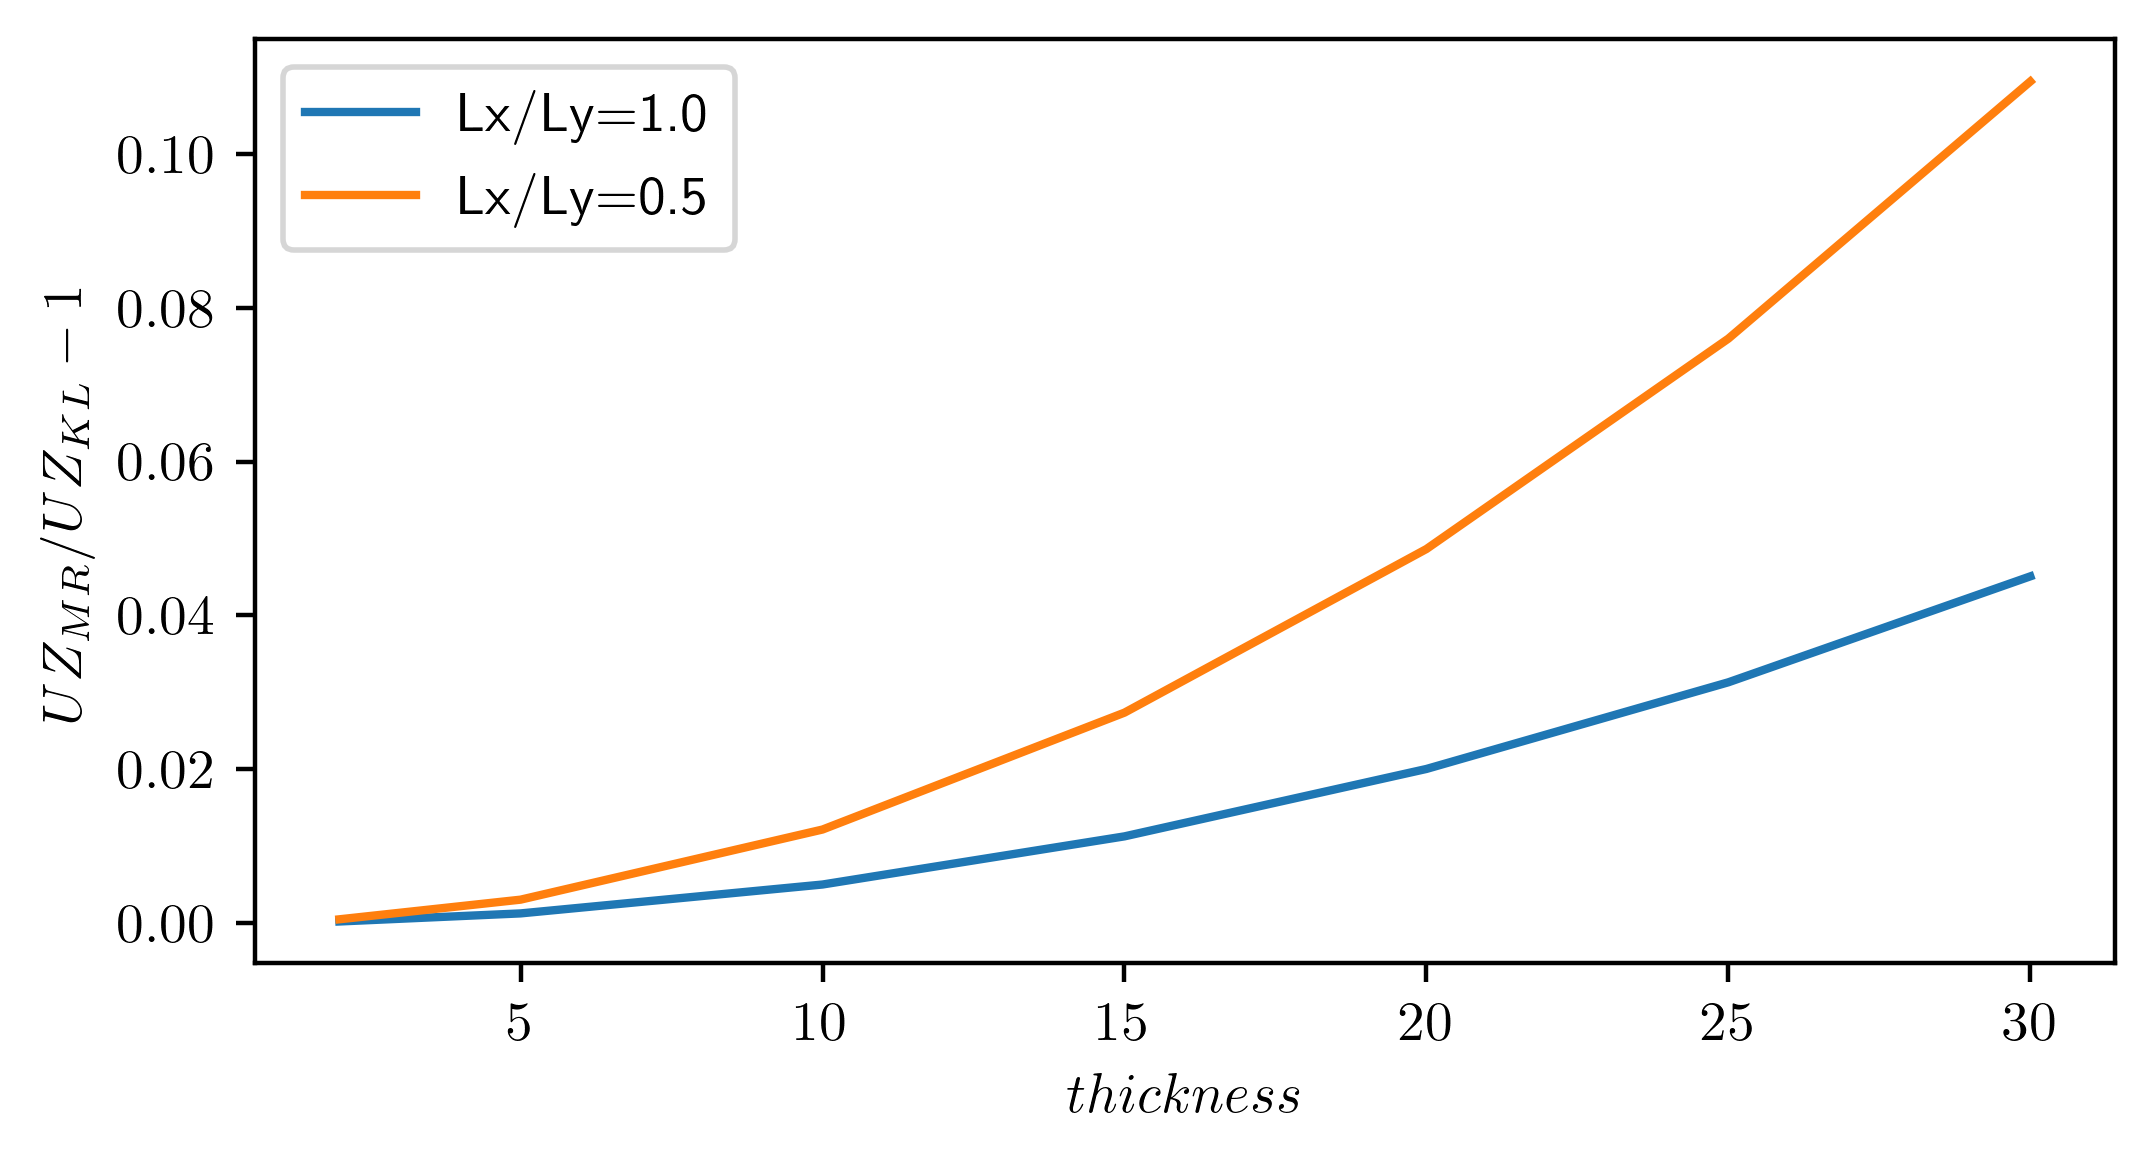

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(6, 3), dpi=400, sharex=True)

thicknesses = [2, 5, 10, 15, 20, 25, 30]

size = (800, 800)
width_ratio = size[0] / size[1]
absdiff = generate_plot_data(size, thicknesses)
axs.plot(thicknesses, absdiff, label="Lx/Ly={}".format(width_ratio))

size = (400, 800)
width_ratio = size[0] / size[1]
absdiff = generate_plot_data(size, thicknesses)
axs.plot(thicknesses, absdiff, label="Lx/Ly={}".format(width_ratio))

axs.set_xlabel("$thickness$")
axs.set_ylabel("$UZ_{MR}/UZ_{KL} - 1 $")
axs.legend()

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
    }
)